### Path setup & Libraries :

In [1]:
project_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF'


In [2]:
lib_path = project_path+'\libraries'
port_path = project_path + '\Data\portfolio'
zc_curve_path = project_path+'\Data\ZC Curve'
diff_path = project_path + '\Data\Diffusion'
MC_path =  project_path +'\Results\Full MC'
img_path = project_path +'\Results\Images'

In [3]:
import numpy as np
import pandas as pd

import  numpy as np

import pickle
from time import time
from datetime import timedelta

from PIL import Image
import matplotlib.pyplot as plt

# importing pacakge 
import sys         
sys.path.append(lib_path)        
from main import *
from FinancialData import *

C:\Users\omirinioui\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Data extraction :

In [4]:
ZCR = ZC_Data_extractor(zc_curve_path)
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 

nbr_fx =  10
nbr_swap = 600
portfolio = Multi_FX_irs_portfolio( nbr_fx, nbr_swap)

#load portfolio data
portfolio.reset_portfolio_from_excel(port_path, '\port600irs10fx.xlsx')

T = portfolio.last_maturity

In [5]:
portfolio.irs_specs

array([(0., 0.25, 100000., 0.04473561, 2.5, 'reciver', 7),
       (0., 0.25,  70000., 0.0495388 , 1. , 'payer', 3),
       (0., 0.25,  90000., 0.04679434, 1. , 'payer', 9),
       (0., 0.5 ,  60000., 0.02958941, 7. , 'payer', 6),
       (0., 1.  ,  40000., 0.0377977 , 6.5, 'reciver', 3),
       (0., 1.  ,  90000., 0.02586477, 7.5, 'reciver', 5),
       (0., 1.  ,  20000., 0.0458065 , 4.5, 'reciver', 6),
       (0., 0.5 ,  10000., 0.04592901, 2. , 'payer', 1),
       (0., 1.  , 100000., 0.02235853, 2. , 'payer', 9),
       (0., 0.25, 100000., 0.04150736, 6.5, 'reciver', 6),
       (0., 0.25,  10000., 0.04176027, 2. , 'payer', 8),
       (0., 0.25,  50000., 0.04205143, 7.5, 'reciver', 2),
       (0., 0.5 , 100000., 0.04384751, 4. , 'payer', 6),
       (0., 0.25, 100000., 0.03102544, 3. , 'payer', 2),
       (0., 0.25,  30000., 0.04814816, 3. , 'payer', 6),
       (0., 0.5 ,  60000., 0.03369468, 3. , 'payer', 9),
       (0., 0.25, 100000., 0.04944313, 5.5, 'reciver', 7),
       (0., 1.  ,

In [6]:
#load diffusion data
with open(diff_path+'\MC10000p600s10f', 'rb') as f1:
    diffusion = pickle.load(f1)

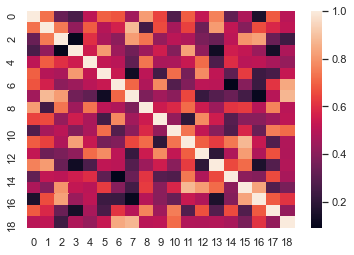

In [7]:
cov = diffusion.covariance_matrix

import seaborn as sns
 
#plotting the heatmap for correlation
ax = sns.heatmap(cov)

In [8]:
#load MC data
with open(MC_path+'\EE_MC_P600sf10', 'rb') as f1:
    mc_df = pickle.load(f1)
    EE_MC = pickle.load(f1)
mc_df.round(1)



,Nodes Number,Mtm,CVA MC,time
0,50.0,-75806.8,208.4,198.6
1,100.0,-75806.8,210.4,376.2
2,200.0,-75806.8,210.7,715.2
3,300.0,-75806.8,210.3,1020.6
4,400.0,-75806.8,210.7,1397.3
5,500.0,-75806.8,210.4,1826.1


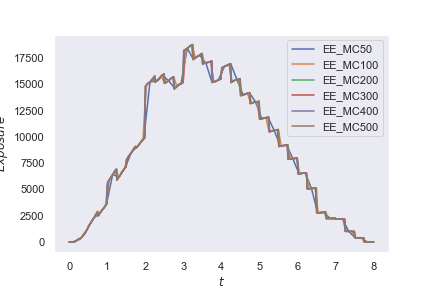

In [9]:
display(Image.open(img_path+'\EE_MC_P600sf10.png'))

      As benchmark we take the full pricing by Monte Carlo using 10000 simulations on 500 time steps wich was calculated in 30 min

# 1. Interpolation on time :   

## 1.1. CVA by Bayesian Quadrature :

In [10]:
#recovery rate & defult probability parameter :
R, lamda = 0.4, 0.005

time : 25.93207859992981
Nodes numbers 5


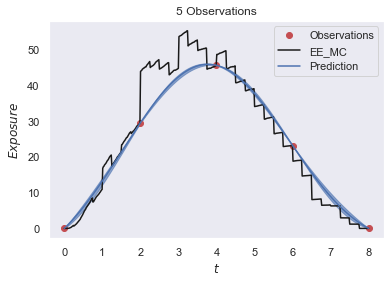

time : 49.534369468688965
Nodes numbers 10


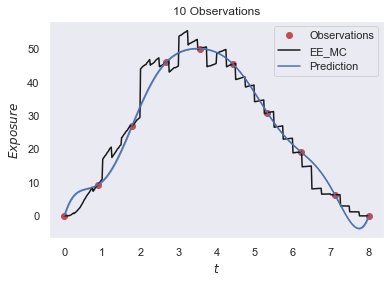

time : 73.51824879646301
Nodes numbers 15


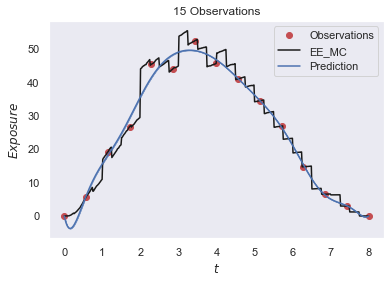

time : 111.67441630363464
Nodes numbers 20


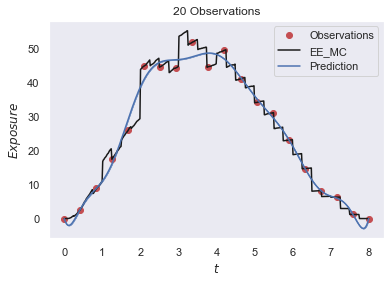

time : 155.7938573360443
Nodes numbers 25


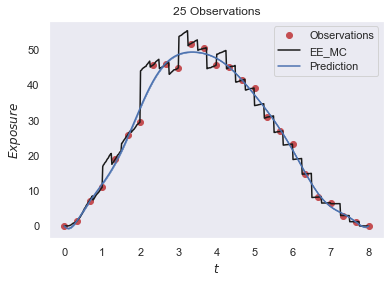

time : 164.36974382400513
Nodes numbers 30


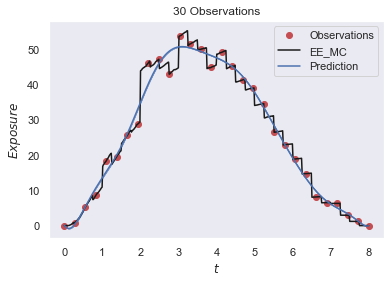

time : 169.69327473640442
Nodes numbers 35


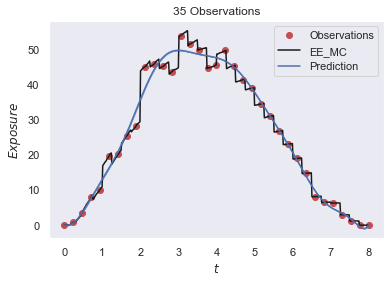

time : 178.76705241203308
Nodes numbers 40


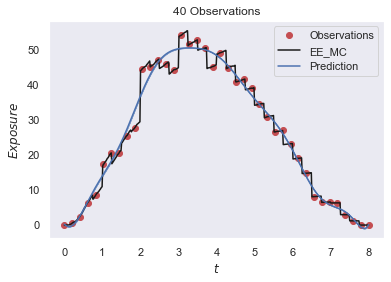

In [11]:

lb , ub = 0,T
x_plot = np.linspace(lb, ub, 300)[:, None]

d = 5
nd = 8

bq_df = pd.DataFrame(columns=['Nodes Number','BQ', 'time', 'Var'])

for i in range(nd):
    start_time = time()
   
    integ_points = np.linspace(0,T,(i+1)*d) 
    
    X = np.array([ [t] for t in integ_points ])
    EE = np.array([ [ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)]) ] for t in integ_points ])
    PD = np.array([ [lamda * np.exp(-lamda *t)] for t in integ_points ])
    Y = (1-R)*EE*PD
    
    bq = BQ(X,Y, lb, ub)
    
    sec_time =time()-start_time
    print('time :', sec_time)
    
    bq_df.loc[len(bq_df)] = [(i+1)*d,bq.integrate()[0] ,sec_time, bq.integrate()[1]]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
    Y_MC = (1-R)*EE_MC*PD_full
    
    mu_plot, var_plot = bq.predict(x_plot)
    
    print('Nodes numbers', (i+1)*d)
    plt.figure()
    plt.plot(X, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="EE_MC")

    plt.plot(x_plot, mu_plot, "C0", label="Prediction")
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
    plt.savefig(img_path+ '/P600F1_BQ'+ str(i)+'.png')
    plt.show()

In [12]:
idx = 5
mtm = mc_df['Mtm'].values[0]

bq = bq_df.copy()
bq['Relative_Error %'] = bq_df['BQ'].apply(lambda x: 100*abs(x - mc_df.iloc[idx]['CVA MC'] )/mc_df.iloc[idx]['CVA MC'] )
bq['Error per Mtm'] =  bq_df['BQ'].apply(lambda x: 1000*abs(x - mc_df.iloc[idx]['CVA MC'])/abs(mtm) )
bq['Time Reduction'] =  bq_df['time'].apply(lambda x: int(mc_df.iloc[idx]['time']/x) )

bq.round(2)


,Nodes Number,BQ,time,Var,Relative_Error %,Error per Mtm,Time Reduction
0,5.0,202.50,25.93,0.68,3.75,0.10,70
1,10.0,208.42,49.53,0.00,0.93,0.03,36
2,15.0,207.67,73.52,0.00,1.29,0.04,24
3,20.0,208.06,111.67,0.00,1.10,0.03,16
4,25.0,206.02,155.79,0.00,2.07,0.06,11
5,30.0,210.34,164.37,0.00,0.02,0.00,11
6,35.0,209.91,169.69,0.00,0.23,0.01,10
7,40.0,211.85,178.77,0.00,0.70,0.02,10


 where $Error \: per \: MtM = \frac{|CVA_{predicted} \, - \, CVA_{Benchmark} |}{|MtM_{0}|}$ expressed in point basis

## 1.2. CVA by chebyshev interpolation 

time : 25.030741691589355
Nodds numbers 5


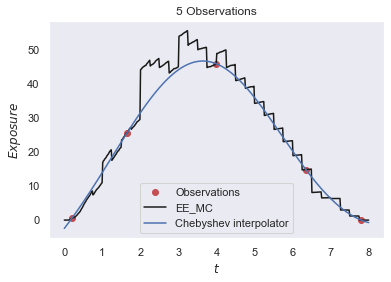

time : 47.53065896034241
Nodds numbers 10


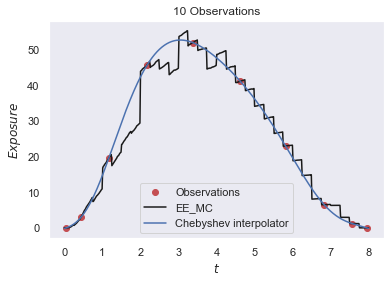

time : 70.78875017166138
Nodds numbers 15


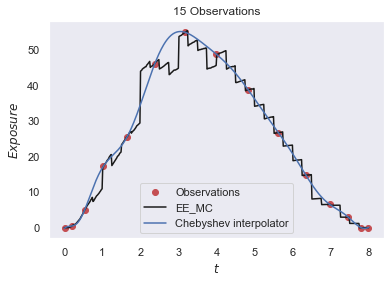

time : 103.5379409790039
Nodds numbers 20


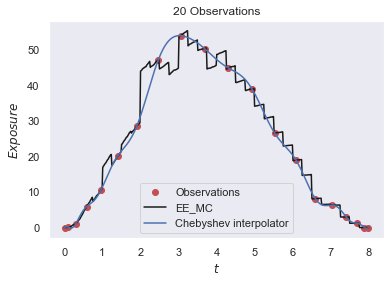

time : 124.81030058860779
Nodds numbers 25


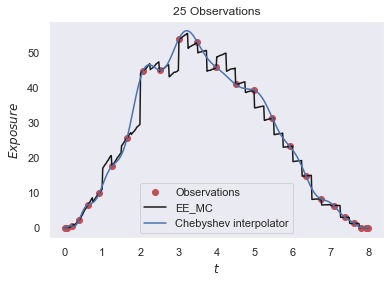

time : 152.83451533317566
Nodds numbers 30


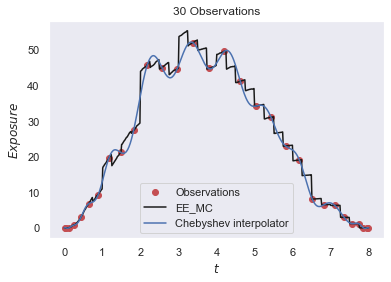

time : 171.20208191871643
Nodds numbers 35


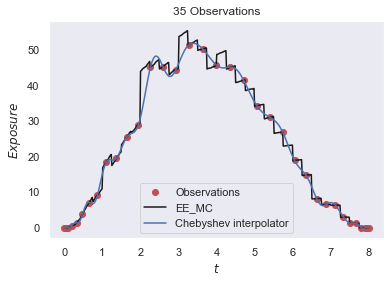

time : 188.567076921463
Nodds numbers 40


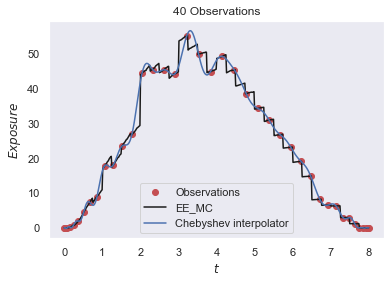

In [13]:

lb , ub = 0,T


integration_grid = np.linspace(0,T,500)
d = 5
nd = 8

cheb_df = pd.DataFrame(columns=['Nodes Number','Chebyshev', 'time'])

for i in range(nd):
    start_time = time()
   
    integ_points = Chebyshev_points(0, T, (i+1)*d)[::-1]

    EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)])  for t in integ_points ])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in integ_points])
    Y = (1-R)*EE*PD
    
    
    EE_cheb = np.array([eval_Barycentric(EE, integ_points, t) for t in integration_grid])
    
    PD = np.array([ lamda * np.exp(-lamda *t) for t in integration_grid ])
    Y_cheb = (1-R)*EE_cheb*PD
    cva = (np.diff(integration_grid)*Y_cheb[1:]).sum()
    
    
    sec_time =time()-start_time
    print('time :', sec_time)
    
    cheb_df.loc[len(cheb_df)] = [(i+1)*d,cva ,sec_time]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
    Y_MC = (1-R)*EE_MC*PD_full
    

    print('Nodds numbers', (i+1)*d)
    plt.figure()
    plt.plot(integ_points, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="EE_MC")

    plt.plot(integration_grid, Y_cheb, "C0", label="Chebyshev interpolator")

    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
    plt.savefig(img_path+ '/P600F1_Chebychev'+ str(i)+'.png')
    plt.show()

In [14]:
cheb = cheb_df.copy()
cheb['Relative_Error %'] = cheb_df['Chebyshev'].apply(lambda x: 100*abs(x - mc_df.iloc[idx]['CVA MC'] )/mc_df.iloc[idx]['CVA MC'] )
cheb['Error per Mtm'] =  cheb_df['Chebyshev'].apply(lambda x: 1000*abs(x - mc_df.iloc[idx]['CVA MC'] )/abs(mtm) )
cheb['Time Reduction'] =  cheb_df['time'].apply(lambda x: int(mc_df.iloc[idx]['time']/x) )
cheb.round(2)

,Nodes Number,Chebyshev,time,Relative_Error %,Error per Mtm,Time Reduction
0,5.0,197.40,25.03,6.17,0.17,72
1,10.0,218.60,47.53,3.91,0.11,38
2,15.0,217.61,70.79,3.43,0.10,25
3,20.0,208.75,103.54,0.78,0.02,17
4,25.0,214.92,124.81,2.15,0.06,14
5,30.0,206.59,152.83,1.80,0.05,11
6,35.0,206.52,171.20,1.83,0.05,10
7,40.0,213.11,188.57,1.30,0.04,9


    We observe that Chebyshev interploartor fit better the Expected exposure than the GPR in the same cost approximately : 1 to 4 min. However, BQ estimates better the CVA value ! 

- We suggest the following explication :

      In fact Chebyshev convergence properties are well etablished for smooth functions (Continously differentiable or analytic). In the other hand, we have convergence properties for more irregular functions (Sobolev functions) in the framework of Bayesian Quadrature or GPR.
      
      In this study case the Expected exposure is not somooth enough to expect good results from Chebychev interpolator ! Howver bayesian quadrartue can infer better the targeted CVA.

## 2. Interpolation on risk factors :

     We use here the same method for time interpolation (BQ for example) in order to compare the performance of BQ and Chebyshev interpolation when they are used to build a proxy of the Mark-to-market as function of risk factors 

    We chose the number of training point to be 10 for GPR and 5 for Chebyshev ! 
    ( We tested different values and 15 for each method seem to perform in accuracy/spped )


In [15]:
train_size_on_x = 5

time : 9.047085285186768
Nodds numbers 5


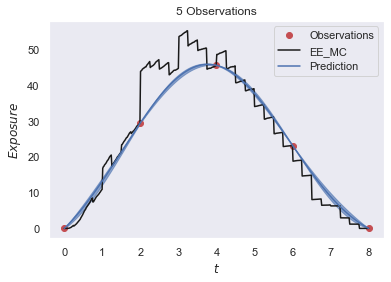

time : 24.372994422912598
Nodds numbers 10


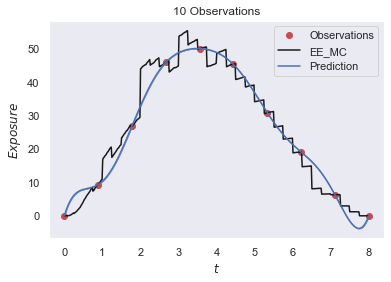

time : 39.389063596725464
Nodds numbers 15


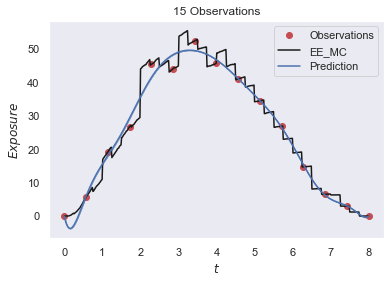

time : 62.84761381149292
Nodds numbers 20


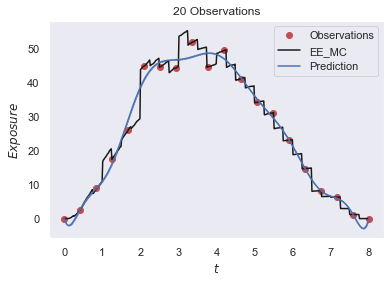

time : 75.49742460250854
Nodds numbers 25


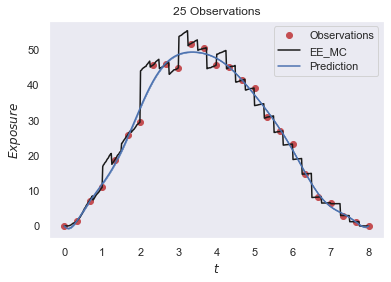

time : 89.62629175186157
Nodds numbers 30


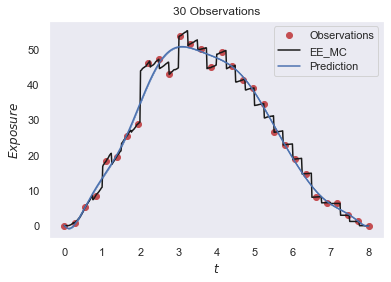

time : 118.69080758094788
Nodds numbers 35


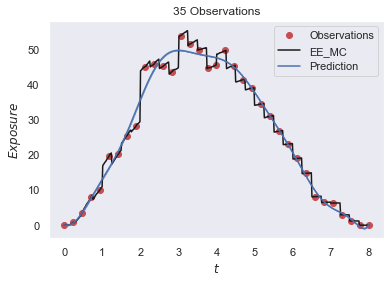

time : 127.45245337486267
Nodds numbers 40


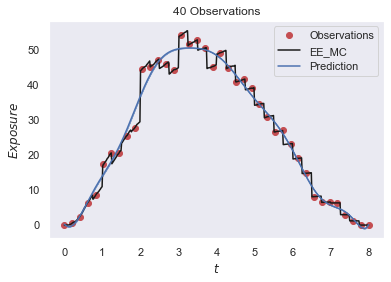

In [16]:
d = 5
nd = 8

bqgp_df = pd.DataFrame(columns=['Nodes Number','BQ-GPR', 'time', 'Var'])

for i in range(nd):
    start_time = time()
   
    integ_points = np.linspace(0,T,(i+1)*d) 
    
    X = np.array([ [t] for t in integ_points ])
    EE = np.array([ [ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)], GPR=True, train_size=train_size_on_x) ] if t>0 else [0] for t in integ_points ])
    PD = np.array([ [lamda * np.exp(-lamda *t)] for t in integ_points ])
    Y = (1-R)*EE*PD
    
    bq = BQ(X,Y, lb, ub)
    
    sec_time =time()-start_time
    print('time :', sec_time)
    
    bqgp_df.loc[len(bqgp_df)] = [(i+1)*d,bq.integrate()[0] ,sec_time, bq.integrate()[1]]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
    Y_MC = (1-R)*EE_MC*PD_full
    
    mu_plot, var_plot = bq.predict(x_plot)
    
    print('Nodds numbers', (i+1)*d)
    plt.figure()
    plt.plot(X, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="EE_MC")

    plt.plot(x_plot, mu_plot, "C0", label="Prediction")
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
    plt.savefig(img_path+ '/P600F10_BQ_GPR__trained'+str(train_size_on_x)+'X'+ str(i)+'t'+'.png')
    plt.show()

In [17]:
bqgp = bqgp_df.copy()
bqgp['Relative_Error %'] = bqgp_df['BQ-GPR'].apply(lambda x: 100*abs(x - mc_df.iloc[idx]['CVA MC'] )/mc_df.iloc[idx]['CVA MC'] )
bqgp['Error per Mtm'] =  bqgp_df['BQ-GPR'].apply(lambda x: 1000*abs(x - mc_df.iloc[idx]['CVA MC'])/abs(mtm) )
bqgp['Time Reduction'] =  bqgp_df['time'].apply(lambda x: int(mc_df.iloc[idx]['time']/x) )

bqgp.round(2)

,Nodes Number,BQ-GPR,time,Var,Relative_Error %,Error per Mtm,Time Reduction
0,5.0,202.50,9.05,0.68,3.75,0.10,201
1,10.0,208.36,24.37,0.00,0.96,0.03,74
2,15.0,207.62,39.39,0.00,1.31,0.04,46
3,20.0,208.03,62.85,0.00,1.12,0.03,29
4,25.0,206.02,75.50,0.00,2.07,0.06,24
5,30.0,210.29,89.63,0.00,0.05,0.00,20
6,35.0,209.88,118.69,0.00,0.24,0.01,15
7,40.0,211.81,127.45,0.00,0.68,0.02,14


time : 6.100870609283447
Nodds numbers 5


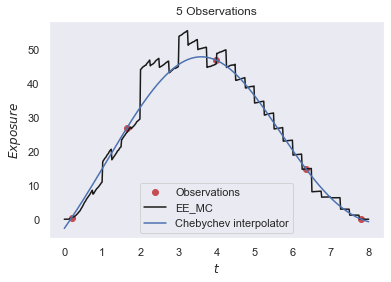

time : 12.925637006759644
Nodds numbers 10


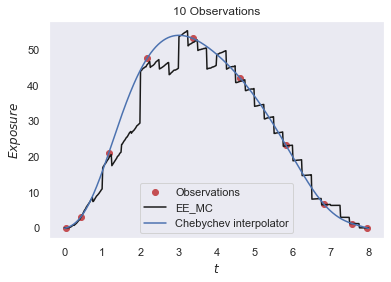

time : 18.126524209976196
Nodds numbers 15


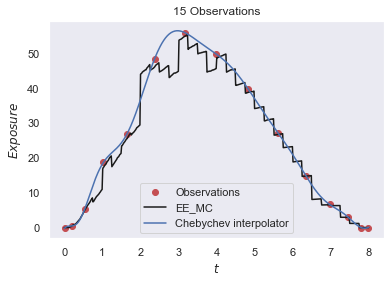

time : 22.49958038330078
Nodds numbers 20


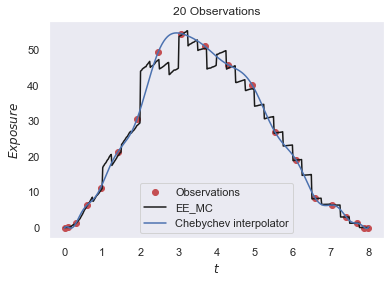

time : 34.108598470687866
Nodds numbers 25


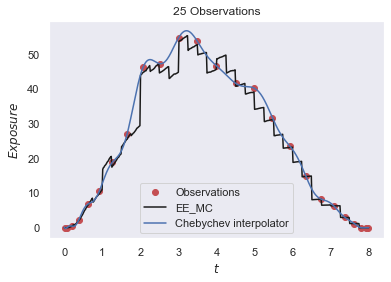

time : 34.001426696777344
Nodds numbers 30


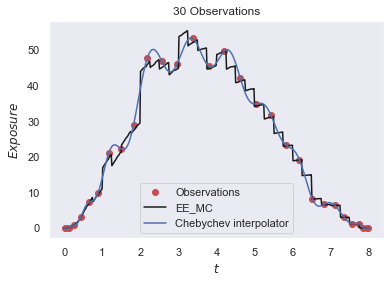

In [ ]:
train_size_on_x = 3

integration_grid = np.linspace(0,T,500)
d = 5
nd = 8

cheb2D_df = pd.DataFrame(columns=['Nodes Number','Chebychev', 'time'])

for i in range(nd):
    start_time = time()
   
    integ_points = Chebyshev_points(0, T, (i+1)*d)[::-1]

    EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)], Chebychev=True, train_size=train_size_on_x)  for t in integ_points ])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in integ_points])
    Y = (1-R)*EE*PD
    
    
    EE_cheb = np.array([eval_Barycentric(EE, integ_points, t) for t in integration_grid])
    
    PD = np.array([ lamda * np.exp(-lamda *t) for t in integration_grid ])
    Y_cheb = (1-R)*EE_cheb*PD
    cva = (np.diff(integration_grid)*Y_cheb[1:]).sum()
    
    
    sec_time =time()-start_time
    print('time :', sec_time)
    
    cheb2D_df.loc[len(cheb2D_df)] = [(i+1)*d,cva ,sec_time]
    
    PD_full = np.array([ lamda * np.exp(-lamda *t) for t in np.linspace(0,T,len(EE_MC)) ])
    Y_MC = (1-R)*EE_MC*PD_full
    

    print('Nodds numbers', (i+1)*d)
    plt.figure()
    plt.plot(integ_points, Y, "ro", markersize=6, label="Observations")
    plt.plot(np.linspace(0,T,len(EE_MC)), Y_MC, "k", label="EE_MC")

    plt.plot(integration_grid, Y_cheb, "C0", label="Chebychev interpolator")

    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title( str((i+1)*d) + ' Observations')
    plt.savefig(img_path+ '/P600F10_Chebychev_Chebychev__trained'+str(train_size_on_x)+'X'+ str(i)+'t'+'.png')
    plt.show()

In [ ]:
chebcheb = cheb2D_df.copy()
chebcheb['Relative_Error %'] = cheb2D_df['Chebychev'].apply(lambda x: 100*abs(x - mc_df.iloc[idx]['CVA MC'] )/mc_df.iloc[idx]['CVA MC'] )
chebcheb['Error per Mtm'] =  cheb2D_df['Chebychev'].apply(lambda x: 1000*abs(x - mc_df.iloc[idx]['CVA MC'])/abs(mtm) )
chebcheb['Time Reduction'] =  cheb2D_df['time'].apply(lambda x: int(mc_df.iloc[idx]['time']/x) )

chebcheb.round(2)

      By training on risk factor we achive a better performance with the same previous accuracy  

      As we said before, we observe that Bayesian Quadrature estimates better the CVA in the same cost approximately : 20 secoonds to 2 min for a relative error in the order of 1% to 2%  

### Suggestion : 

    Numerical test suggest us to use Chebyshev for the interpolation on risk factor and the Bayesian quadrature for time interpolation unless we expect a smooth exposure (for example a long or short IRS portfolio)